<a class="anchor" id="toc"></a>
# Table of Contents

1. [Install libraries](#install-libraries)
1. [Import libraries](#import-libraries)
1. [Load and clean dataset](#load-and-clean-dataset)
1. [Split data, Vectorize (TF-IDF) and Binarize](#split-data-vectorize-tf-idf-and-binarize)
1. [Implement NSA](#implement-nsa)
1. [Validation](#validation)
1. [Evaluate](#evaluate)

<a class="anchor" id="install-libraries"></a>
# Install libraries

In [34]:
# install requirements from requirements.txt
%pip install -r ../requirements.txt

<a class="anchor" id="import-libraries"></a>
# Import libraries

In [35]:
# Basic data handling
import pandas as pd
import numpy as np
import re

# Machine learning & text processing
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    classification_report, confusion_matrix,
    precision_recall_curve, f1_score, auc
)

# Sparse matrix operations
import scipy.sparse as sp

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
from tabulate import tabulate

# Utility
from dataclasses import dataclass
import pickle





<a class="anchor" id="load-and-clean-dataset"></a>
# Load and clean dataset

Here we load the dataset and clean it by :
- converting to lowercase
- removing html tags
- remove whitespace
- replace URLs and emails with placeholders

The cleaned text is stored in a new column 'cleaned_message'and the labels are encoded as 0 for 'ham' and 1 for 'spam'.




In [55]:
# Load dataset
df = pd.read_csv('../data/SMSSpamCollection', sep='\t', names=['label', 'message'])
#df.head()

# data cleaning function
'''we will remove html tags, urls, punctuation, numbers, emails, and extra whitespace.
but we will keep the option to not remove urls and emails if needed in future because they might be relevant for spam detection.'''

def clean_text(text: str) -> str:
    if pd.isna(text) or not isinstance(text, str): # check for NaN or non-string
        return ""

    text = text.lower()

    # replace URLs
    text = re.sub(r'http\S+|www\S+', ' <URL> ', text)

    # replace emails
    text = re.sub(r'\S+@\S+', ' <EMAIL> ', text)

    # remove html tags (very rare in SMS)
    text = re.sub(r'<[^>]+>', ' ', text)

    # keep numbers, letters, placeholders
    text = re.sub(r'[^a-z0-9<> ]+', ' ', text)

    # collapse whitespace
    text = re.sub(r'\s+', ' ', text).strip()

    return text

# apply cleaning

df['cleaned_message'] = df['message'].apply(clean_text)
# encode labels
df['label'] = df['label'].map({'ham': 0, 'spam': 1})

# compare original and cleaned messages to see the effect of cleaning
df[['message', 'cleaned_message']].head(10)




,message,cleaned_message
0,"Go until jurong point, crazy.. Available only ...",go until jurong point crazy available only in ...
1,Ok lar... Joking wif u oni...,ok lar joking wif u oni
2,Free entry in 2 a wkly comp to win FA Cup fina...,free entry in 2 a wkly comp to win fa cup fina...
3,U dun say so early hor... U c already then say...,u dun say so early hor u c already then say
4,"Nah I don't think he goes to usf, he lives aro...",nah i don t think he goes to usf he lives arou...
5,FreeMsg Hey there darling it's been 3 week's n...,freemsg hey there darling it s been 3 week s n...
6,Even my brother is not like to speak with me. ...,even my brother is not like to speak with me t...
7,As per your request 'Melle Melle (Oru Minnamin...,as per your request melle melle oru minnaminun...
8,WINNER!! As a valued network customer you have...,winner as a valued network customer you have b...
9,Had your mobile 11 months or more? U R entitle...,had your mobile 11 months or more u r entitled...


The cleaning function is working as we want and we advance with this implementation.

<a class="anchor" id="split-data-vectorize-tf-idf-and-binarize"></a>
# Split data, Vectorize (TF-IDF) and Binarize
## Split data
We want to split the data into:
- training set (60% of ham because the model is trained only on ham): used for training the NSA model
- validation set (20% of the rest of the data): used for tuning hyperparameters
- test set (20% of the rest of the data): used for evaluating the final model

In [10]:
# Separete ham and spam
ham = df[df['label'] == 0]['cleaned_message']
spam = df[df['label'] == 1]['cleaned_message']

print(f"Total ham messages: {len(ham)}")
print(f"Total spam messages: {len(spam)}")

# split function
def create_train_val_test_splits(df: pd.DataFrame, 
                                   text_col: str,
                                   train_ratio: float = 0.6,
                                   random_state: int = 42):
    """
    Split ham/spam data into train/val/test sets.
    
    Train: 60% of ham only
    Val: 20% ham + 50% spam
    Test: 20% ham + 50% spam
    """
    ham = df[df['label'] == 0][text_col]
    spam = df[df['label'] == 1][text_col]
    
    # Split ham
    ham_train, ham_temp = train_test_split(ham, train_size=train_ratio, 
                                            random_state=random_state)
    ham_val, ham_test = train_test_split(ham_temp, test_size=0.5, 
                                          random_state=random_state)
    
    # Split spam
    spam_val, spam_test = train_test_split(spam, test_size=0.5, 
                                            random_state=random_state)
    
    return {
        'ham_train': ham_train, 'ham_val': ham_val, 'ham_test': ham_test,
        'spam_val': spam_val, 'spam_test': spam_test
    }
splits = create_train_val_test_splits(df, text_col='cleaned_message')

# table showing the distribution of messages 
table = [
    ["Train", len(splits['ham_train']), 0],
    ["Validation", len(splits['ham_val']), len(splits['spam_val'])],
    ["Test", len(splits['ham_test']), len(splits['spam_test'])],
    ["Total", len(splits['ham_train']) + len(splits['ham_val']) + len(splits['ham_test']), 
    len(splits['spam_val']) + len(splits['spam_test'])]
]
print(tabulate(table, headers=["Set", "Ham", "Spam"], tablefmt="github"))

Total ham messages: 4825
Total spam messages: 747
| Set        |   Ham |   Spam |
|------------|-------|--------|
| Train      |  2895 |      0 |
| Validation |   965 |    373 |
| Test       |   965 |    374 |
| Total      |  4825 |    747 |


## Vectorize (TF-IDF)
To vectorize the message we chose to use TfidfVectorizer which is a scikit-learn tool that turns a pile of text into numbers our model will be able to use. The vectorizer can be customized with different parameters to fit our needs and the parameters we chose to change are:
- `max_df=0.95`: This parameter ignores terms that appear in more than 95% of the documents, which helps to remove common words that may not be informative.
- `min_df=2`: This parameter ignores terms that appear in fewer than 2 documents, which helps to eliminate rare words that may not contribute significantly to the model.
- `ngram_range=(1, 2)`: This parameter considers both single words (unigrams) and pairs of consecutive words (bigrams), which can capture more context and improve the model's understanding of the text.
- `sublinear_tf=True`: This parameter applies sublinear term frequency scaling, which can help to reduce the impact of very frequent terms and improve the model's performance.

This is the vectorizer we will use for now but we might experiment with other vectorizers later if we find it necessary.


In [11]:

# Vectorizer for normal cleaned messages
vectorizer = TfidfVectorizer(
    ngram_range=(1, 2),
    max_df=0.95,
    min_df=2,
    sublinear_tf=True
)

Xh_train = vectorizer.fit_transform(splits['ham_train'])
Xh_val   = vectorizer.transform(splits['ham_val'])
Xh_test   = vectorizer.transform(splits['ham_test'])
Xs_val   = vectorizer.transform(splits['spam_val'])
Xs_test   = vectorizer.transform(splits['spam_test'])
print("Vocabulary (plain):", len(vectorizer.vocabulary_))
print("Train matrix shape (plain):", Xh_train.shape)



Vocabulary (plain): 7012
Train matrix shape (plain): (2895, 7012)


from 2895 spam messages we got 7012 unique tokens after vectorization.

## Binarize
We change the TF-IDF values to binary values (0 and 1) based on a threshold tau. If the TF-IDF value is greater than tau, it is set to 1; otherwise, it is set to 0. Binarization is necessary for the NSA model because it relies on binary feature representations to detect anomalies effectively.

In [12]:
# binarization function
def binarize_matrix(X: sp.csr_matrix, tau: float = 0.01) -> sp.csr_matrix:
    X_bin = (X >= tau).astype(np.uint8)
    density = X_bin.nnz / (X_bin.shape[0] * X_bin.shape[1])
    print(f"density={density:.6f}")
    return X_bin

# apply binarization
tau = 0.01
Xh_train_bin = binarize_matrix(Xh_train, tau)
Xh_val_bin   = binarize_matrix(Xh_val, tau)
Xh_test_bin  = binarize_matrix(Xh_test, tau)
Xs_val_bin   = binarize_matrix(Xs_val, tau)
Xs_test_bin  = binarize_matrix(Xs_test, tau)
# sanity check
print("Binarized train matrix shape (url_email):", Xh_train_bin.shape)

density=0.002408
density=0.001945
density=0.001985
density=0.002182
density=0.002178
Binarized train matrix shape (url_email): (2895, 7012)


the shapes match our TF-IDF shapes so that is good. the density is quit low but that is something we will be tuning during validation if it did not work out.

<a class="anchor" id="implement-nsa"></a>
# NSA implementation

This NSA builds binary detectors in three steps:
- Compute antiprofile sampling weights from ham feature frequencies so rare tokens are favoured.
- Repeatedly sample `k` active indices, draw a radius in `[r_min, r_max]`, and keep only detectors whose overlaps with ham stay below that radius.
- Stack the accepted detectors into a sparse matrix so predictions can batch-check overlap counts against the `k_hits` threshold (with optional score outputs and pickle-based save/load).

In [41]:
@dataclass
class Detector:
    idx: np.ndarray   # active bits indices
    radius: int       # required overlap threshold
    
class VDetectorNSA_Binary:
    """
    Binary Negative Selection Algorithm using r-overlap matching rule.
    Detectors are binary sparse vectors that should NOT match any self sample
    with overlap >= radius.
    """
    def __init__(self,
                 k: int,                 # active bits per detector
                 r_min: int, r_max: int, # min/max overlap radius
                 max_detectors: int,     # how many detectors to accept
                 max_tries: int,         # max attempts to generate
                 batch_size: int,        # batch size for overlap calc
                 sampling: str = "antiprofile",
                 random_state: int = 42):
        self.k = k
        self.r_min = r_min
        self.r_max = r_max
        self.max_detectors = max_detectors
        self.max_tries = max_tries
        self.batch_size = batch_size
        self.sampling = sampling
        self.random_state = random_state

        self.dim = None
        self.detectors: list[Detector] = []
        self.p_detect = None
        np.random.seed(self.random_state)

    # --------------------------------------------------------------
    # internal helpers
    # --------------------------------------------------------------
    def _build_antiprofile_probs(self, X_ham_train: sp.csr_matrix) -> None:
        """Build antiprofile sampling probabilities from self data."""
        assert sp.issparse(X_ham_train)
        p_ham = (X_ham_train.sum(axis=0) / X_ham_train.shape[0]).A1
        p = np.clip(1.0 - p_ham, 1e-8, 1.0)
        self.p_detect = p / p.sum()

    def _sample_indices(self) -> np.ndarray:
        """Sample k unique indices for a detector."""
        if self.sampling == "antiprofile" and self.p_detect is not None:
            return np.sort(np.random.choice(self.dim, size=min(self.k, self.dim),
                                            replace=False, p=self.p_detect))
        return np.sort(np.random.choice(self.dim, size=min(self.k, self.dim),
                                        replace=False))


    # --------------------------------------------------------------
    # main API
    # --------------------------------------------------------------
    def fit(self, X_ham_train: sp.csr_matrix):
        """Train the NSA model by generating detectors that do not match self samples."""
        assert sp.issparse(X_ham_train), "Input must be a sparse matrix."
        self.dim = X_ham_train.shape[1]
        if self.sampling == "antiprofile":
            self._build_antiprofile_probs(X_ham_train)

        accepted, tries = 0, 0
        while accepted < self.max_detectors and tries < self.max_tries:
            tries += 1
            idx = self._sample_indices()
            det_vec = self._vec_from_idx(idx, self.dim)

            # choose a random radius within the allowed range
            r = np.random.randint(self.r_min, self.r_max + 1)

            # reject if detector matches any ham within radius
            m_o = self._max_overlap(X_ham_train, det_vec, self.batch_size)
            if m_o >= r:      # too similar to self, reject
                continue

            # accept detector
            self.detectors.append(Detector(idx=idx, radius=r))
            accepted += 1

        print(f"Generated {accepted} detectors after {tries} tries.")
        return self

    def predict(self, X_bin: sp.csr_matrix, k_hits: int = 1, return_score: bool = False):
        """Predict non-self (1=spam) vs self (0=ham)."""
        assert self.detectors, "Model not fitted."
        n = X_bin.shape[0]
        predictions = np.zeros(n, dtype=np.uint8)

        # build detector matrix
        rows, cols, data, r_list = [], [], [], []
        for i, det in enumerate(self.detectors):
            cols.extend(det.idx.tolist())
            rows.extend([i] * len(det.idx))
            data.extend([1] * len(det.idx))
            r_list.append(det.radius)
        det_matrix = sp.csr_matrix((data, (rows, cols)), shape=(len(self.detectors), self.dim))
        r_array = np.array(r_list)

        scores = np.zeros(n, dtype=np.int32) if return_score else None
        for s in range(0, n, self.batch_size):
            e = min(s + self.batch_size, n)
            overlaps = (X_bin[s:e] @ det_matrix.T).A
            hits = (overlaps >= r_array)
            if return_score:
                scores[s:e] = hits.sum(axis=1)
            if k_hits == 1:
                predictions[s:e] = hits.any(axis=1).astype(np.uint8)
            else:
                predictions[s:e] = (hits.sum(axis=1) >= k_hits).astype(np.uint8)
        return predictions if not return_score else (predictions, scores)
    
    def save(self, filepath: str) -> None:
        """Save the trained model to a file."""
        with open(filepath, 'wb') as f:
            pickle.dump(self, f)
    
    def load(self, filepath: str) -> None:
        """Load a trained model from a file."""
        with open(filepath, 'rb') as f:
            model = pickle.load(f)
        self.__dict__.update(model.__dict__)

<a class="anchor" id="validation"></a>
# Validation

In [42]:
nsa = VDetectorNSA_Binary(
    k=20,
    r_min=1, r_max=3,
    max_detectors=2000,
    max_tries=50000,
    sampling="antiprofile",
    random_state=42,
    batch_size=1000
).fit(Xh_train_url_bin)


Generated 2000 detectors after 5785 tries.


In [43]:
# build eval set
X_eval = sp.vstack([Xh_val_url_bin, Xs_val_url_bin])
y_eval = np.hstack([np.zeros(Xh_val_url_bin.shape[0], dtype=np.uint8),
                    np.ones(Xs_val_url_bin.shape[0], dtype=np.uint8)])

y_pred, scores = nsa.predict(X_eval, k_hits=1, return_score=True)

              precision    recall  f1-score   support

         ham       0.73      0.96      0.83       965
        spam       0.49      0.10      0.17       373

    accuracy                           0.72      1338
   macro avg       0.61      0.53      0.50      1338
weighted avg       0.67      0.72      0.65      1338

PR-AUC: 0.394
PR-AUC: 0.394


np.float64(0.3942289920933569)

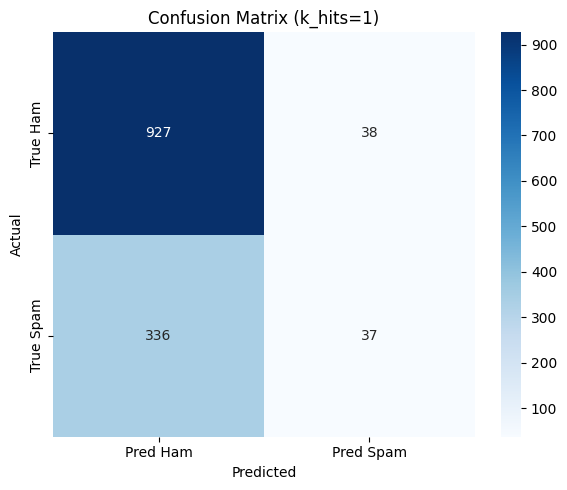

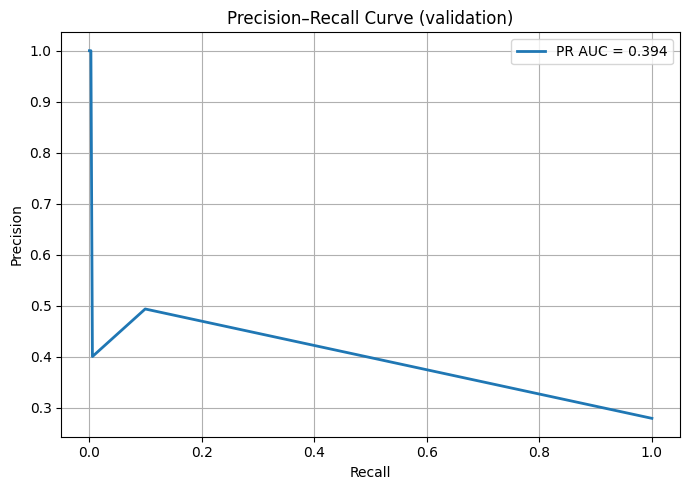

In [44]:
def print_classification_metrics(y_true, y_pred, target_names=("ham", "spam")):
    """Print the scikit-learn classification report and return it."""
    report = classification_report(y_true, y_pred, target_names=target_names)
    print(report)
    return report


def plot_confusion_matrix_heatmap(y_true, y_pred, labels=("ham", "spam"), title="Confusion Matrix", ax=None):
    """Plot a confusion matrix heatmap for the given ground-truth and predictions."""
    cm = confusion_matrix(y_true, y_pred)
    cm_df = pd.DataFrame(cm,
                      index=[f"True {label.title()}" for label in labels],
                      columns=[f"Pred {label.title()}" for label in labels])
    if ax is None:
        _, ax = plt.subplots(figsize=(6, 5))
    sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues', ax=ax)
    ax.set_title(title)
    ax.set_ylabel("Actual")
    ax.set_xlabel("Predicted")
    plt.tight_layout()
    return cm_df


def plot_precision_recall_curve(y_true, scores, title="Precision–Recall Curve", ax=None, label=None, show_legend=True):
    """Plot a precision–recall curve and return the computed AUC.

    If `ax` is provided the curve is drawn onto that axis so multiple
    curves can be overlaid. `label` can be used to identify the run.
    """
    precision, recall, _ = precision_recall_curve(y_true, scores)
    pr_auc = auc(recall, precision)
    if label is None:
        entry_label = f"PR AUC = {pr_auc:.3f}"
    else:
        entry_label = f"{label} (AUC={pr_auc:.3f})"

    if ax is None:
        fig, ax = plt.subplots(figsize=(7, 5))
        ax.plot(recall, precision, linewidth=2, label=entry_label)
        ax.set_xlabel("Recall")
        ax.set_ylabel("Precision")
        ax.set_title(title)
        ax.grid(True)
        if show_legend:
            ax.legend()
        plt.tight_layout()
        return pr_auc
    else:
        ax.plot(recall, precision, linewidth=2, label=entry_label)
        if show_legend:
            ax.legend()
        return pr_auc


def evaluate_model(y_true, y_pred, scores, target_names=("ham", "spam"), cm_title="Confusion Matrix", pr_title="Precision–Recall Curve", pr_ax=None, pr_label=None, show_pr_legend=True):
    """Convenience wrapper that prints metrics and plots evaluation charts.

    If `pr_ax` is provided the precision–recall curve will be drawn into that
    axis (allowing overlays). `pr_label` will be used as the legend label.
    """
    print_classification_metrics(y_true, y_pred, target_names=target_names)
    # plot confusion matrix on its own figure/axis
    plot_confusion_matrix_heatmap(y_true, y_pred, labels=target_names, title=cm_title)

    # plot precision-recall on shared axis if given (no new figure), otherwise create one
    pr_auc = plot_precision_recall_curve(y_true, scores, title=pr_title, ax=pr_ax, label=pr_label, show_legend=show_pr_legend)
    if pr_ax is None:
        print(f"PR-AUC: {pr_auc:.3f}")
    else:
        print(f"Added PR curve: {pr_label if pr_label is not None else ''} (AUC={pr_auc:.3f})")
    return pr_auc


#
evaluate_model(
    y_true=y_eval,
    y_pred=y_pred,
    scores=scores,
    target_names=("ham", "spam"),
    cm_title="Confusion Matrix (k_hits=1)",
    pr_title="Precision–Recall Curve (validation)"
)


because the density was too small to start with it looks like our model is straggling to get the spam messages now we will try to tune the parameters to see if we get better results.

In [45]:
# train with lower radius to make the detectors even more sensitive 
nsa_tuned_radius = VDetectorNSA_Binary(
    k=20,
    r_min=1, r_max=2,  # lowered max radius
    max_detectors=2000,
    max_tries=50000,
    sampling="antiprofile",
    random_state=42,
    batch_size=1000
).fit(Xh_train_url_bin)

Generated 2000 detectors after 26063 tries.


              precision    recall  f1-score   support

         ham       0.75      0.81      0.78       965
        spam       0.38      0.30      0.34       373

    accuracy                           0.67      1338
   macro avg       0.56      0.56      0.56      1338
weighted avg       0.65      0.67      0.66      1338

PR-AUC: 0.332
PR-AUC: 0.332


np.float64(0.3317560621497557)

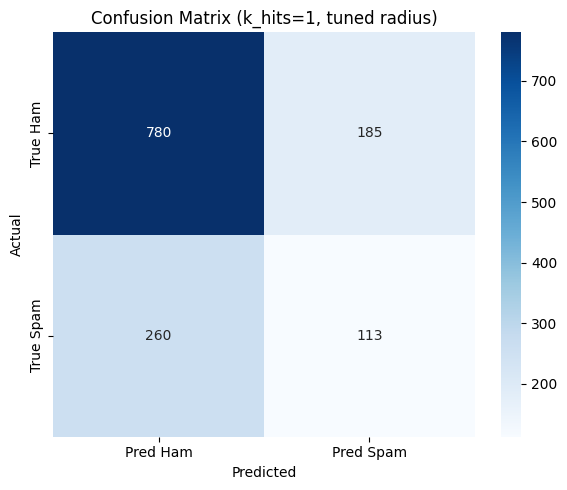

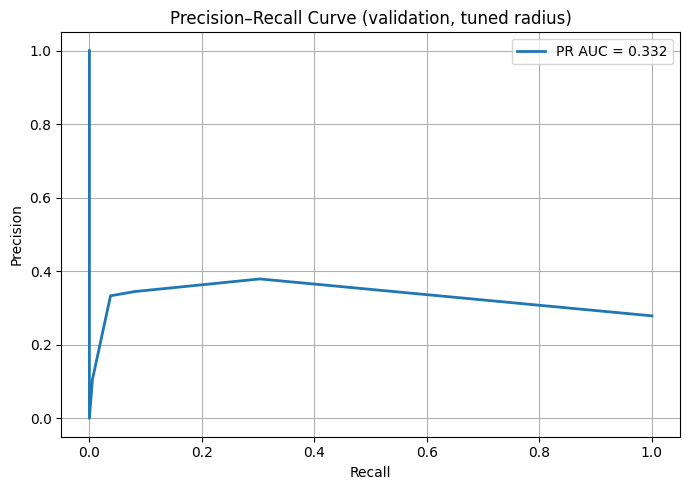

In [46]:
y_pred, scores = nsa_tuned_radius.predict(X_eval, k_hits=1, return_score=True)

# evaluate again
evaluate_model(
    y_true=y_eval,
    y_pred=y_pred,
    scores=scores,
    target_names=("ham", "spam"),
    cm_title="Confusion Matrix (k_hits=1, tuned radius)",
    pr_title="Precision–Recall Curve (validation, tuned radius)"
)

from the results we can see the the performance gets worse on every metrics exept for recall. This means lowering radius made the spam recall increase a little, ham false postive exploded and precision, F1 and PR-AUC suffered.

- high radius --> barely any matches --> low recall
- low radius  --> accidental matches --> false postives explode

that is why we are going back to radius 1-3 and we will try to increase detectors instead.


--- Testing with 3000 detectors ---
Generated 3000 detectors after 8675 tries.
              precision    recall  f1-score   support

         ham       0.73      0.93      0.82       965
        spam       0.39      0.11      0.17       373

    accuracy                           0.70      1338
   macro avg       0.56      0.52      0.50      1338
weighted avg       0.64      0.70      0.64      1338

Generated 3000 detectors after 8675 tries.
              precision    recall  f1-score   support

         ham       0.73      0.93      0.82       965
        spam       0.39      0.11      0.17       373

    accuracy                           0.70      1338
   macro avg       0.56      0.52      0.50      1338
weighted avg       0.64      0.70      0.64      1338

Added PR curve: 3000 detectors (AUC=0.331)

--- Testing with 4000 detectors ---
Added PR curve: 3000 detectors (AUC=0.331)

--- Testing with 4000 detectors ---
Generated 4000 detectors after 11605 tries.
              preci

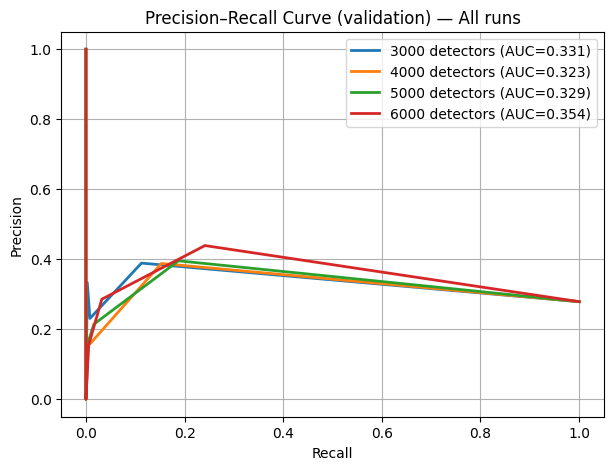

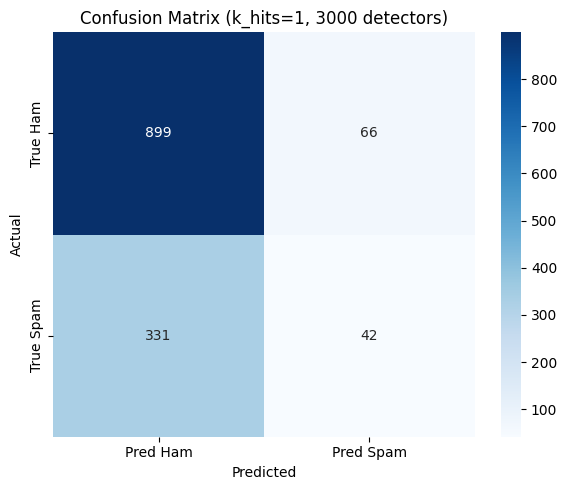

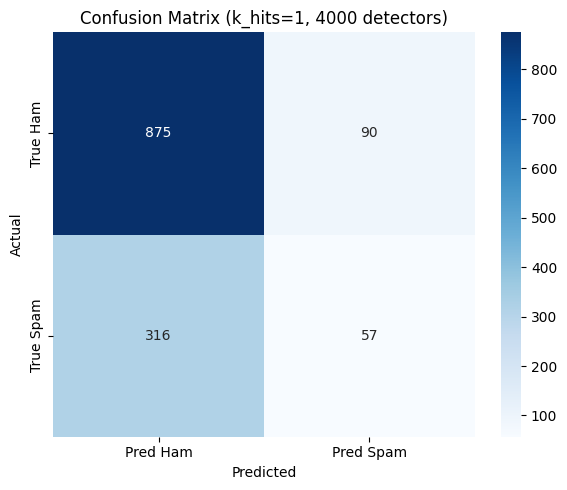

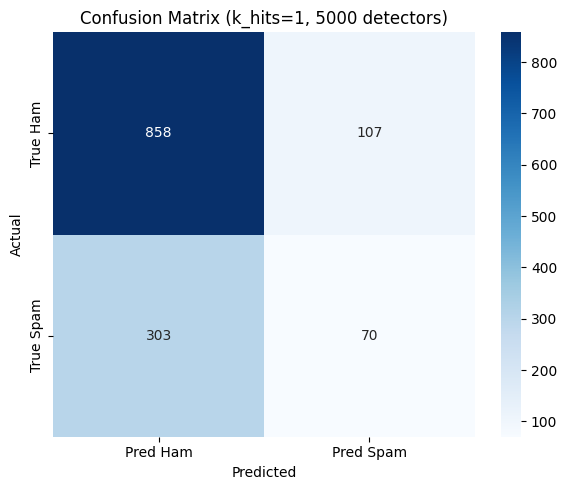

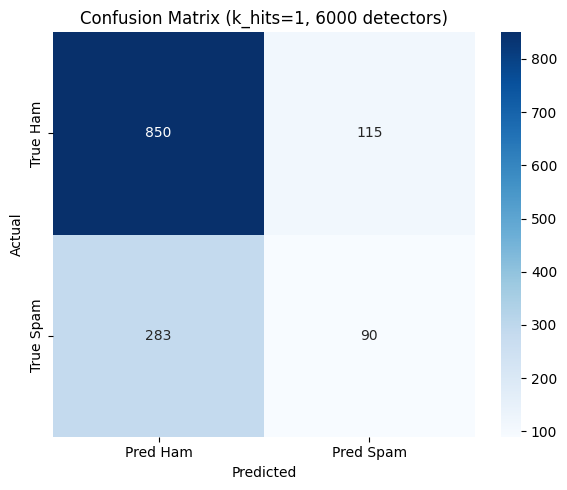

In [47]:
# we will test with different number of detectors now
fig_pr, ax_pr = plt.subplots(figsize=(7, 5))
for num_detectors in [3000, 4000, 5000, 6000]:
    print(f"\n--- Testing with {num_detectors} detectors ---")
    nsa_tuned_detectors = VDetectorNSA_Binary(
        k=20,
        r_min=1, r_max=3,  # back to original radius
        max_detectors=num_detectors,
        max_tries=50000,
        sampling="antiprofile",
        random_state=42,
        batch_size=1000
    ).fit(Xh_train_url_bin)

    y_pred, scores = nsa_tuned_detectors.predict(X_eval, k_hits=1, return_score=True)

    # evaluate again: confusion matrix is shown per-run, PR curve is overlaid on ax_pr
    evaluate_model(
        y_true=y_eval,
        y_pred=y_pred,
        scores=scores,
        target_names=("ham", "spam"),
        cm_title=f"Confusion Matrix (k_hits=1, {num_detectors} detectors)",
        pr_title=f"Precision–Recall Curve (validation, {num_detectors} detectors)",
        pr_ax=ax_pr,
        pr_label=f"{num_detectors} detectors",
        show_pr_legend=False
    )

# finalize the combined PR plot (show legend once)
ax_pr.set_title("Precision–Recall Curve (validation) — All runs")
ax_pr.set_xlabel("Recall")
ax_pr.set_ylabel("Precision")
ax_pr.grid(True)
ax_pr.legend()
plt.tight_layout()
plt.show()


we see that the spam recall and pr-auc values are increasing slightly with increase in the number of detectors but at the same time ham false postive grow slightly the problem is the model being sparse the the right thing to do from here is to switch to char-level TF-IDF with ngram range of (3, 5) . with that we could 
- get way more active features 
- better density

In [48]:
# make a char level TF-IDF vectorizer with ngram range (3, 5)
vectorizer_char = TfidfVectorizer(
    ngram_range=(3, 5),
    max_df=0.95,
    min_df=2,
    sublinear_tf=True,
    analyzer='char_wb'
)

Xh_train_char = vectorizer_char.fit_transform(ham_with_url_email)
Xh_val_char   = vectorizer_char.transform(ham_val_with_url_email)
Xh_test_char  = vectorizer_char.transform(ham_test_with_url_email)
Xs_val_char   = vectorizer_char.transform(spam_val_with_url_email)
Xs_test_char  = vectorizer_char.transform(spam_test_with_url_email)

print("Vocabulary (char-level):", len(vectorizer_char.vocabulary_))
print("Train matrix shape (char-level):", Xh_train_char.shape)

# apply binarization
tau = 0.01
Xh_train_char_bin = binarize_matrix(Xh_train_char, tau)
Xh_val_char_bin   = binarize_matrix(Xh_val_char, tau)   
Xh_test_char_bin  = binarize_matrix(Xh_test_char, tau)
Xs_val_char_bin   = binarize_matrix(Xs_val_char, tau)
Xs_test_char_bin  = binarize_matrix(Xs_test_char, tau)  
# sanity check
print("Binarized train matrix shape (char-level):", Xh_train_char_bin.shape)
nsa_char = VDetectorNSA_Binary(
    k=20,
    r_min=1, r_max=3,
    max_detectors=5000,
    max_tries=100000,
    sampling="antiprofile",
    random_state=42,
    batch_size=1000
).fit(Xh_train_char_bin)

Vocabulary (char-level): 21024
Train matrix shape (char-level): (4825, 21024)
density=0.005013
density=0.004802
density=0.004916
density=0.008154
density=0.008072
Binarized train matrix shape (char-level): (4825, 21024)
Generated 5000 detectors after 26614 tries.
Generated 5000 detectors after 26614 tries.


              precision    recall  f1-score   support

         ham       0.87      1.00      0.93       965
        spam       1.00      0.60      0.75       373

    accuracy                           0.89      1338
   macro avg       0.93      0.80      0.84      1338
weighted avg       0.90      0.89      0.88      1338

PR-AUC: 0.856
PR-AUC: 0.856


np.float64(0.8559482160962102)

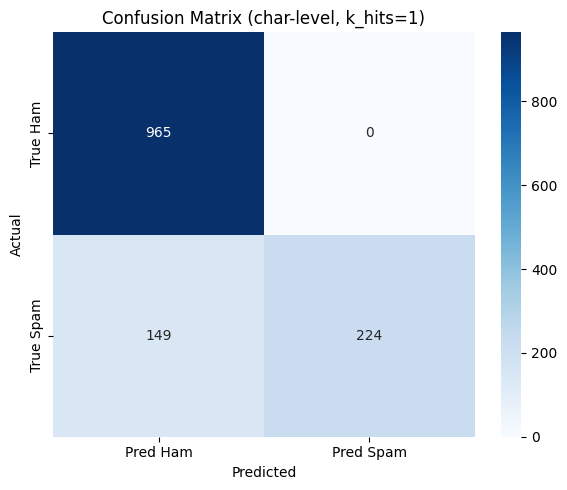

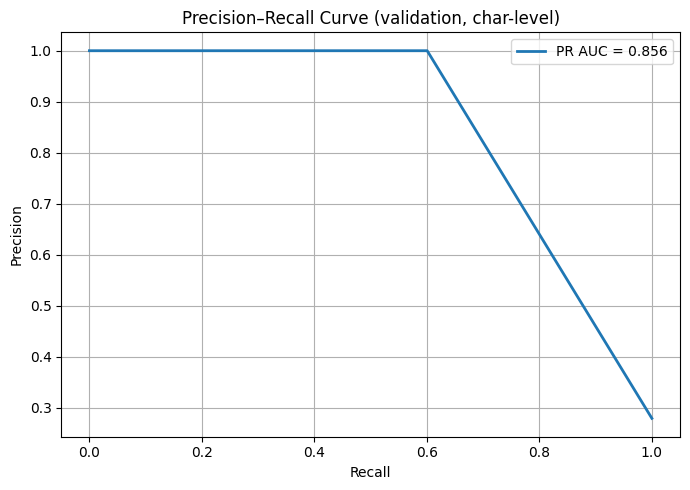

In [49]:
# build val eval set
X_eval_char = sp.vstack([Xh_val_char_bin, Xs_val_char_bin])
y_eval_char = np.hstack([np.zeros(Xh_val_char_bin.shape[0], dtype=np.uint8),
                    np.ones(Xs_val_char_bin.shape[0], dtype=np.uint8)])

# predict and evaluate
y_pred_char, scores_char = nsa_char.predict(X_eval_char, k_hits=1, return_score=True)
evaluate_model(
    y_true=y_eval_char,
    y_pred=y_pred_char,
    scores=scores_char,
    target_names=("ham", "spam"),
    cm_title="Confusion Matrix (char-level, k_hits=1)",
    pr_title="Precision–Recall Curve (validation, char-level)"
)

now this is very good result with:
- good ham protection (the nsa never incorrectly labels ham as spam)
- high spam precision
- reasonable spam recall 
- best PR-AUC so far

Now we will try to tune the parameters for this to get the best possible version.


--- Evaluating with k_hits=1 ---
              precision    recall  f1-score   support

         ham       0.87      1.00      0.93       965
        spam       1.00      0.60      0.75       373

    accuracy                           0.89      1338
   macro avg       0.93      0.80      0.84      1338
weighted avg       0.90      0.89      0.88      1338

Added PR curve: k_hits=1 (AUC=0.856)

--- Evaluating with k_hits=2 ---
              precision    recall  f1-score   support

         ham       0.87      1.00      0.93       965
        spam       1.00      0.60      0.75       373

    accuracy                           0.89      1338
   macro avg       0.93      0.80      0.84      1338
weighted avg       0.90      0.89      0.88      1338

Added PR curve: k_hits=1 (AUC=0.856)

--- Evaluating with k_hits=2 ---
              precision    recall  f1-score   support

         ham       0.79      1.00      0.88       965
        spam       1.00      0.32      0.48       373

    ac

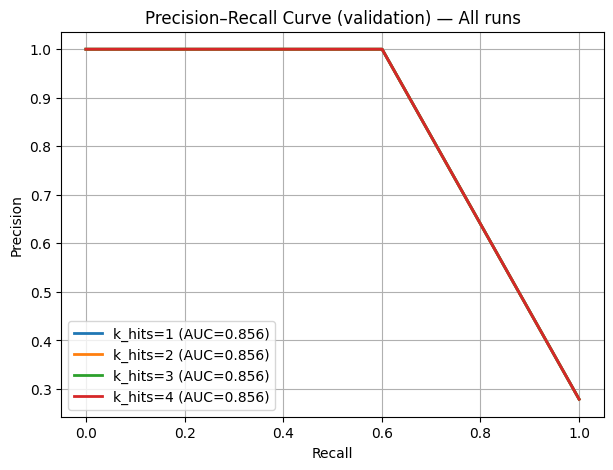

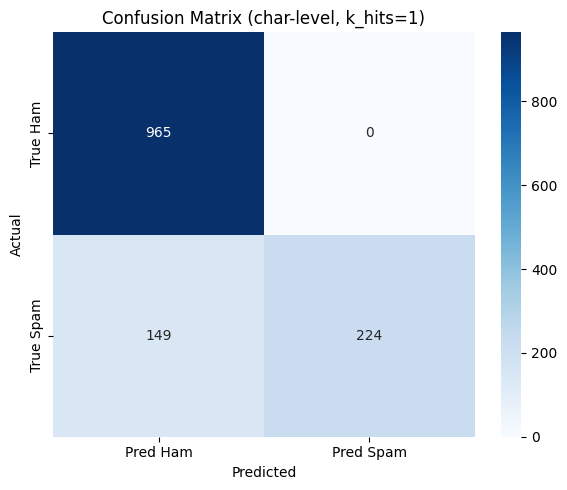

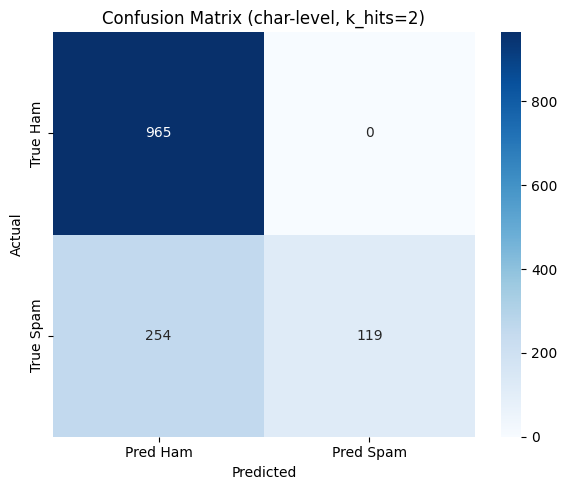

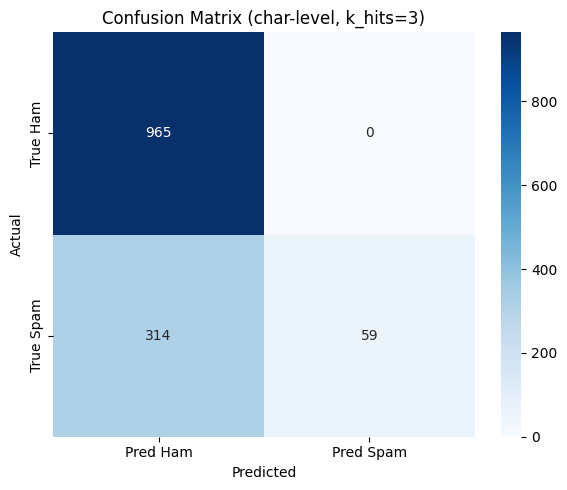

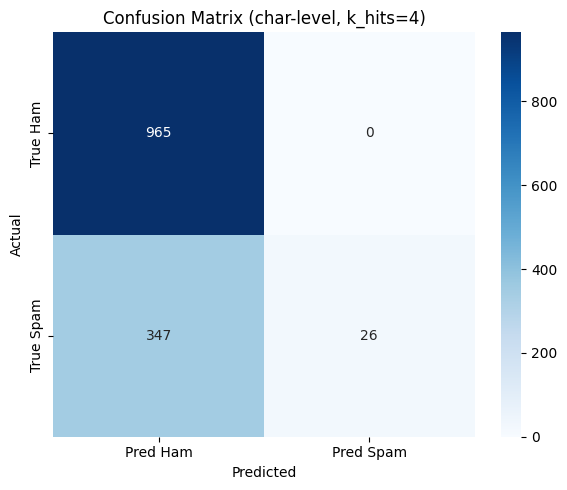

In [50]:
# try with different k_hits values
fig_pr, ax_pr = plt.subplots(figsize=(7, 5))
for k in [1, 2, 3, 4]:
    print(f"\n--- Evaluating with k_hits={k} ---")
    y_pred_k, scores_k = nsa_char.predict(X_eval_char, k_hits=k, return_score=True)
    evaluate_model(
        y_true=y_eval_char,
        y_pred=y_pred_k,
        scores=scores_k,
        target_names=("ham", "spam"),
        cm_title=f"Confusion Matrix (char-level, k_hits={k})",
        pr_title=f"Precision–Recall Curve (validation, char-level, k_hits={k})",
        pr_ax=ax_pr,
        pr_label=f"k_hits={k}",
        show_pr_legend=False
    )

# finalize the combined PR plot (show legend once)
ax_pr.set_title("Precision–Recall Curve (validation) — All runs")
ax_pr.set_xlabel("Recall")
ax_pr.set_ylabel("Precision")
ax_pr.grid(True)
ax_pr.legend()
plt.tight_layout()
plt.show()


as we know k_hits is the dicision threshold(how many detectors need to fire before we call a message spam?)
k_hits = 1 means one hit is enough so it is very senstive while 2, 3, 4 are less senstive and only the clearest spam are flagged.
This is our spam threshold that is why our ham numbers remain solid while our spam numbers when worse with different k_hits.
There for k_hits 1 is the best .

Now we will try to tune the model further by finding  the best tau. lowering tau further can make a rome for more overlaps leading to higher spam recall.



--- Evaluating with tau=0.012 ---
density=0.005013
density=0.004802
density=0.004916
density=0.008154
density=0.008072
Generated 5000 detectors after 26636 tries.
Generated 5000 detectors after 26636 tries.
              precision    recall  f1-score   support

         ham       0.87      1.00      0.93       965
        spam       1.00      0.60      0.75       373

    accuracy                           0.89      1338
   macro avg       0.93      0.80      0.84      1338
weighted avg       0.90      0.89      0.88      1338

              precision    recall  f1-score   support

         ham       0.87      1.00      0.93       965
        spam       1.00      0.60      0.75       373

    accuracy                           0.89      1338
   macro avg       0.93      0.80      0.84      1338
weighted avg       0.90      0.89      0.88      1338

Added PR curve: tau=0.012 (AUC=0.856)

--- Evaluating with tau=0.01 ---
density=0.005013
density=0.004802
density=0.004916
density=0.00815

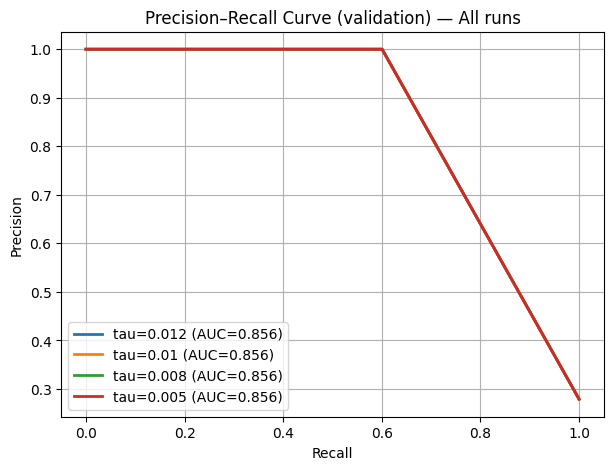

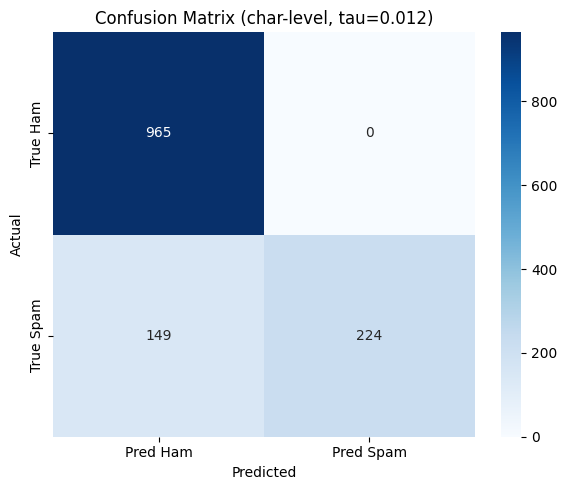

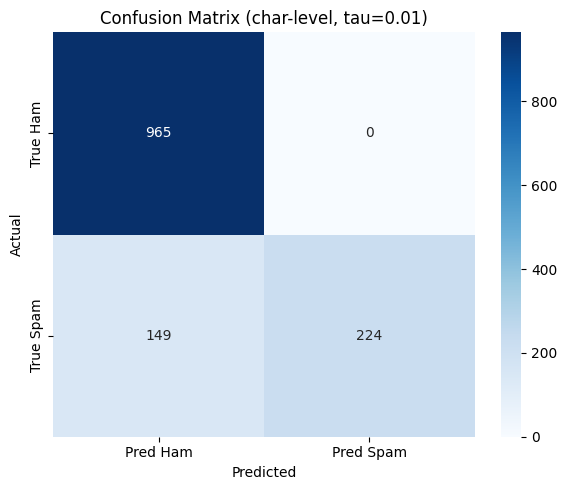

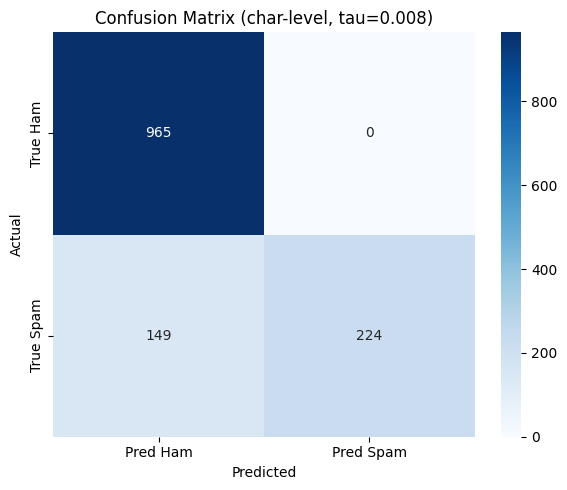

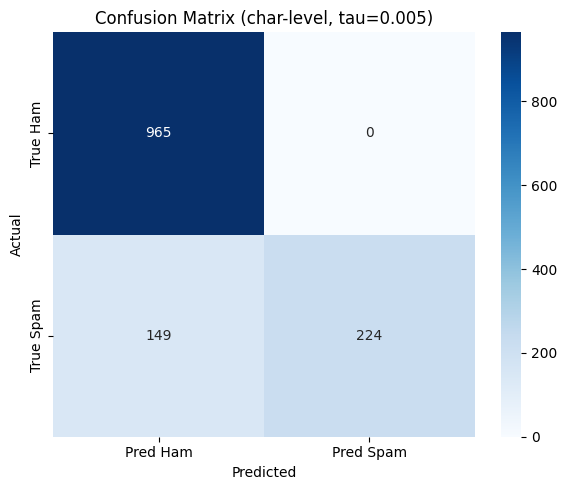

In [51]:
# test with different tau values
tau_values = [0.012, 0.01, 0.008, 0.005]
fig_pr, ax_pr = plt.subplots(figsize=(7, 5))
for tau in tau_values:
    print(f"\n--- Evaluating with tau={tau} ---")
    # re-binarize with new tau
    Xh_train_char_bin_tau = binarize_matrix(Xh_train_char, tau)
    Xh_val_char_bin_tau   = binarize_matrix(Xh_val_char, tau)   
    Xh_test_char_bin_tau  = binarize_matrix(Xh_test_char, tau)
    Xs_val_char_bin_tau   = binarize_matrix(Xs_val_char, tau)
    Xs_test_char_bin_tau  = binarize_matrix(Xs_test_char, tau)  
    # train new NSA model
    nsa_tau = VDetectorNSA_Binary(
        k=20,
        r_min=1, r_max=3,
        max_detectors=5000,
        max_tries=100000,
        sampling="antiprofile",
        random_state=42,
        batch_size=1000
    ).fit(Xh_train_char_bin_tau)
    # build eval set
    X_eval_char_tau = sp.vstack([Xh_val_char_bin_tau, Xs_val_char_bin_tau])
    y_eval_char_tau = np.hstack([np.zeros(Xh_val_char_bin_tau.shape[0], dtype=np.uint8),
                        np.ones(Xs_val_char_bin_tau.shape[0], dtype=np.uint8)])
    # predict and evaluate
    y_pred_tau, scores_tau = nsa_tau.predict(X_eval_char_tau, k_hits=1, return_score=True)
    evaluate_model(
        y_true=y_eval_char_tau,
        y_pred=y_pred_tau,
        scores=scores_tau,
        target_names=("ham", "spam"),
        cm_title=f"Confusion Matrix (char-level, tau={tau})",
        pr_title=f"Precision–Recall Curve (validation, char-level, tau={tau})",
        pr_ax=ax_pr,
        pr_label=f"tau={tau}",
        show_pr_legend=False
    )
# finalize the combined PR plot (show legend once)
ax_pr.set_title("Precision–Recall Curve (validation) — All runs")
ax_pr.set_xlabel("Recall")
ax_pr.set_ylabel("Precision")
ax_pr.grid(True)
ax_pr.legend()
plt.tight_layout()
plt.show()

looks like that did not make any difference that means that every meaningful char-level feature is already strong enough to survive the threshold value.
Now we will test with different k values which is the number of active bits per detector lowering it would in teori give us better recall on spam.


--- Evaluating with k=10 ---
Generated 5000 detectors after 13413 tries.
              precision    recall  f1-score   support

         ham       0.82      1.00      0.90       965
        spam       1.00      0.44      0.61       373

    accuracy                           0.84      1338
   macro avg       0.91      0.72      0.76      1338
weighted avg       0.87      0.84      0.82      1338

Generated 5000 detectors after 13413 tries.
              precision    recall  f1-score   support

         ham       0.82      1.00      0.90       965
        spam       1.00      0.44      0.61       373

    accuracy                           0.84      1338
   macro avg       0.91      0.72      0.76      1338
weighted avg       0.87      0.84      0.82      1338

Added PR curve: k=10 (AUC=0.799)

--- Evaluating with k=15 ---
Added PR curve: k=10 (AUC=0.799)

--- Evaluating with k=15 ---
Generated 5000 detectors after 18879 tries.
              precision    recall  f1-score   support

   

KeyboardInterrupt: 

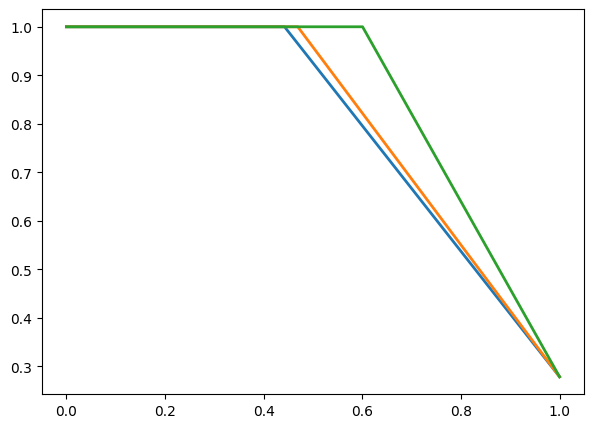

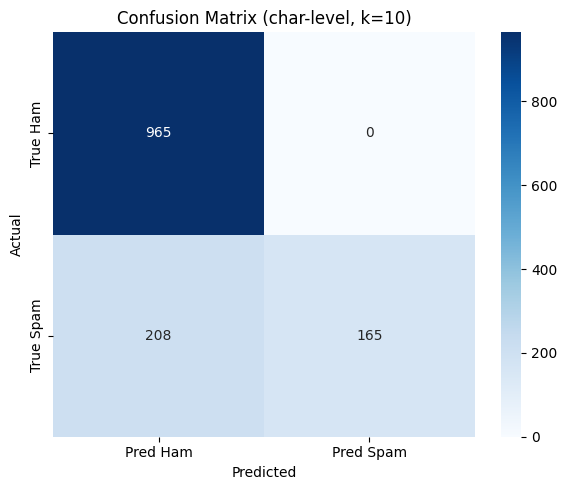

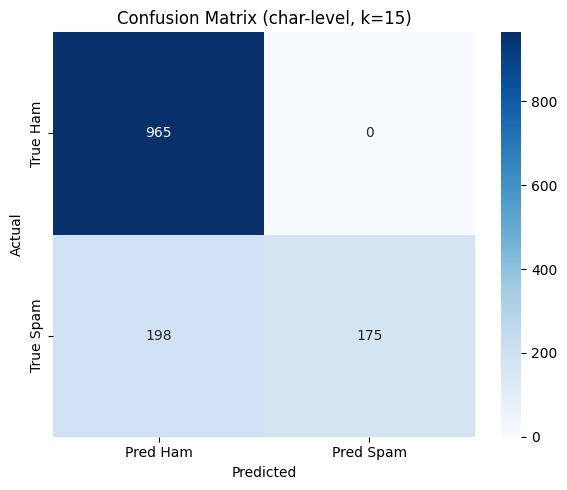

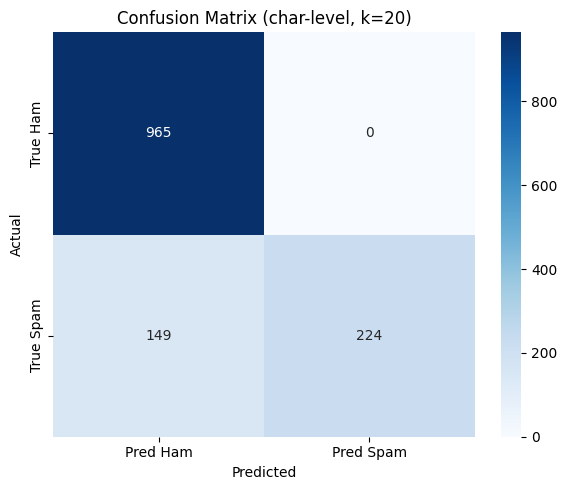

In [52]:
# test with different k values
k_values = [10,15, 20, 25, 30, 35]
fig_pr, ax_pr = plt.subplots(figsize=(7, 5))
for k in k_values:
    print(f"\n--- Evaluating with k={k} ---")
    nsa_k = VDetectorNSA_Binary(
        k=k,
        r_min=1, r_max=3,
        max_detectors=5000,
        max_tries=100000,
        sampling="antiprofile",
        random_state=42,
        batch_size=1000
    ).fit(Xh_train_char_bin)
    # predict and evaluate
    y_pred_k, scores_k = nsa_k.predict(X_eval_char, k_hits=1, return_score=True)
    evaluate_model(
        y_true=y_eval_char,
        y_pred=y_pred_k,
        scores=scores_k,
        target_names=("ham", "spam"),
        cm_title=f"Confusion Matrix (char-level, k={k})",
        pr_title=f"Precision–Recall Curve (validation, char-level, k={k})",
        pr_ax=ax_pr,
        pr_label=f"k={k}",
        show_pr_legend=False
    )
# finalize the combined PR plot (show legend once)
ax_pr.set_title("Precision–Recall Curve (validation) — All runs")
ax_pr.legend()
plt.show()  


it looks like perfomance is getting better with larger detector size but at k = 35 we can see that it did not even manage to hit the max number of detectors producing 4055 detectors that makes 30 more ideal because larger number would require more computational cost from now on .

Therefore, k = 30 represents the optimal detector size, balancing high spam recall, perfect spam precision, and reliable detector generation.

<a class="anchor" id="evaluate"></a>
# Evaluate

Generated 5000 detectors after 65497 tries.
              precision    recall  f1-score   support

         ham       0.91      1.00      0.95       965
        spam       1.00      0.74      0.85       374

    accuracy                           0.93      1339
   macro avg       0.95      0.87      0.90      1339
weighted avg       0.93      0.93      0.92      1339

PR-AUC: 0.906


np.float64(0.9055784307069287)

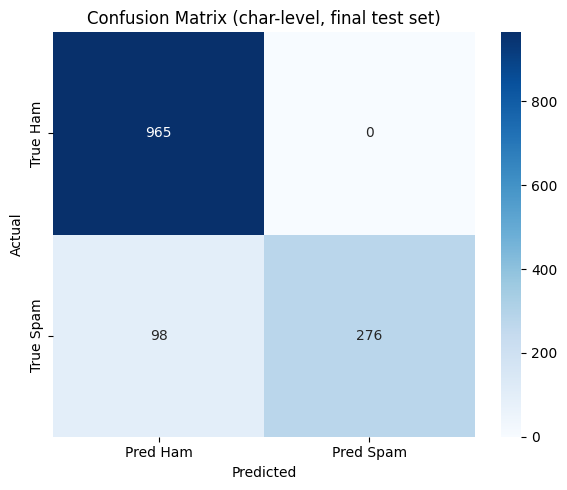

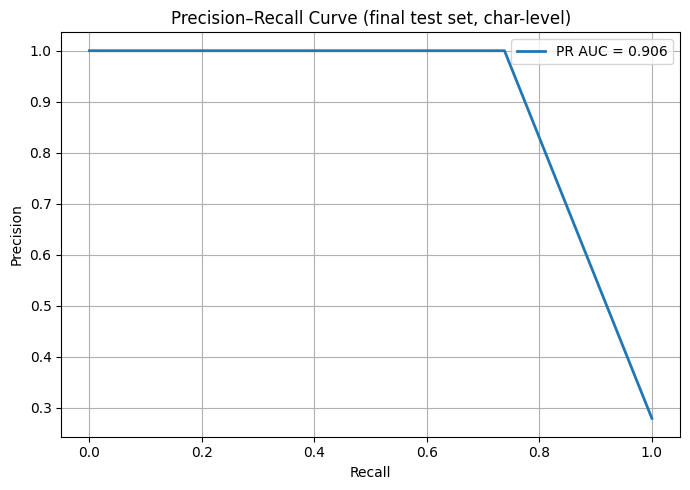

In [ ]:
# # Final evaluation on test set with the best model so far
X_test_final = sp.vstack([Xh_test_char_bin, Xs_test_char_bin])
y_test_final = np.hstack([np.zeros(Xh_test_char_bin.shape[0], dtype=np.uint8),
                    np.ones(Xs_test_char_bin.shape[0], dtype=np.uint8)])

# train final model
nsa_char = VDetectorNSA_Binary(
    k=30,
    r_min=1, r_max=3,
    max_detectors=5000,
    max_tries=100000,
    sampling="antiprofile",
    random_state=42,
    batch_size=1000
).fit(Xh_train_char_bin)

y_pred_final, scores_final = nsa_char.predict(X_test_final, k_hits=1, return_score=True)
evaluate_model(
    y_true=y_test_final,
    y_pred=y_pred_final,
    scores=scores_final,
    target_names=("ham", "spam"),
    cm_title="Confusion Matrix (char-level, final test set)",
    pr_title="Precision–Recall Curve (final test set, char-level)",
)

